## GPU Accelerated Interpretable Machine Learning for Diversified Portfolio Construction

In this notebook, we accelerated a pipeline to benchmark Hierarchical Risk Parity (HRP) relative to Naive Risk Parity (NRP) in the GPU as described in the [paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3730144). It is an example of diversification strategy allocating to liquid multi-asset futures markets with dynamic leverage ("volatility target"). This workflow includes following steps:

* Load csv data of asset daily prices
* Run block bootstrap to generate 100k different scenarios.
* Compute the log returns for each scenario. 
* Compute assets distances to run hierarchical clustering and Hierarchical Risk Parity (HRP) weights for the assets
* Compute the weights for the assets based on the Naïve Risk Parity (NRP) method.
* Compute the transaction cost based on weights adjustment on the rebalancing days
* At every rebalancing date, calculate the portfolio leverage to reach the volatility target.
* Compute the Average annual Returns, Std Returns, Sharpe Ratios, Maximum Drawdown, and Calmar Ratio performance metrics for these two methods (HRP-NRP)

## Background

**Naive Risk Parity**  Naive Risk Parity (NRP), is here called naive because it ignores the correlation among the assets. In an RP portfolio, an asset weight is indirectly proportional to its historical volatility as explained in Roncalli (2013). More formally, the weight $w_i$ for the i-th asset with i spanning the portfolio universe $i =1,...,N$ is
$$ w_i = \frac{\sigma_i^{-1}}{\sum_{j}\sigma_j^{-1}}$$
where $\sigma_i = \sqrt{\sum_{ii}}$ denotes the volatility of asset i.

**HRP** The standard HRP approach (Lopez de Prado (2016a)) uses a tree clustering algorithm to perform a quasi-diagonalization of the covariance matrix. After the quasi-diagonalization is carried
out, a recursive bi-sectioning method is used to define the weights of each asset within the portfolio. 

**Performance metrics**

Statistics | Short | Description
--- | --- | ----
Volatility | SD | Annualized volatility
Returns | RET | Annualized returns
Maximum Drawdown | MDD | Drawdowns percentage
Sharpe ratio | SR | The ratio between returns and volatility (annualized)
Calmar Ratio | Calmar | The ratio between annualized returns and max drawdown


**Backtests**
The strategies are rebalanced every month. At every rebalancing date, the portfolio leverage is set to reach the volatility target of $\sigma_{target} = 5\%$ annualized in a hindsight. The portfolio leverage
determines the total market value of the portfolio and thus the position quantities of each instrument. The estimation of realized volatility used for the updated leverage number is the
maximum of the volatilities of the portfolio measured over 20 and 60 trading days, respectively $\sigma_{t=20}$ and $\sigma_{t=60}$.  The target weight is calculated as
$$W_{target} = \frac{\sigma_{target}} {\max(\sigma_{t=20}, \sigma_{t=60})}$$

Start the Dask cluster for distributed computation

In [1]:
# run this cell if you need Dask
from dask_cuda import LocalCUDACluster
import dask
dask.config.set({"distributed.comm.timeouts.tcp": "90s"})
cluster = LocalCUDACluster()
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:42023 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 251.82 GiB


## Results for the empirical dataset 

Following is the workflow from CSV data loading to backtest performance metrics computation. 

In [2]:
import cupy
import cudf
import matplotlib.pyplot as pl
from greenflow.dataframe_flow import TaskGraph
from IPython.display import display, HTML
taskGraph=TaskGraph.load_taskgraph('./10assets/workflow_empirical.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', 'load_raw_csv'), ('type', 'LoadCsvNode'), ('conf', {'cs…

We can run the workflow by clicking on the button in the widget or we can run following command. The result will be saved in the `result` variable

In [3]:
result = taskGraph.run()

All the intermediate result can be fetched by the keys of `result` variable. We can list all the keys by running: 

In [4]:
result.get_keys()

('hrp_nrp_diff.out',
 'raw.out',
 'log_return.out',
 'assets_order.out',
 'hrp_weight.out',
 'portfolio_construct_hrp.out',
 'portfolio_construct_nrp.out',
 'nrp_weight.out',
 'distance_node.cov_df',
 'distance_node.distance_df',
 'leverage_hrp.lev_df',
 'leverage_nrp.lev_df',
 'performance_nrp.calmar_df',
 'performance_hrp.calmar_df',
 'performance_nrp.sharpe_df',
 'performance_nrp.sd_df',
 'performance_nrp.ret_df',
 'performance_nrp.maxdd_df',
 'performance_hrp.ret_df',
 'performance_hrp.sd_df',
 'performance_hrp.sharpe_df',
 'performance_hrp.maxdd_df')

Let's plot the empirical dataset strategies performances

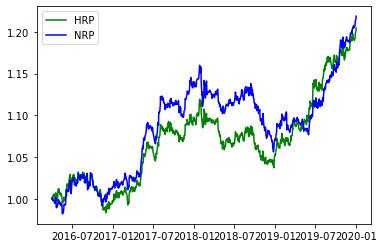

In [5]:
date = result['leverage_nrp.lev_df'].sort_index()['date'].values.get()
pl.plot(date, cupy.exp(cupy.cumsum(result['leverage_hrp.lev_df'].sort_index()['portfolio'].values)).get(), color='g', label='HRP')
pl.plot(date, cupy.exp(cupy.cumsum(result['leverage_nrp.lev_df'].sort_index()['portfolio'].values)).get(), color='b', label='NRP')
pl.legend()

Organize all the performance metrics in a table

In [6]:
nrp_metrics = [result['performance_nrp.sd_df']['portfolio'].values.item(),
               result['performance_nrp.ret_df']['portfolio'].values.item(),
               result['performance_nrp.maxdd_df']['portfolio'].values.item(),
               result['performance_nrp.calmar_df']['portfolio'].values.item(),
               result['performance_nrp.sharpe_df']['portfolio'].values.item()]
hrp_metrics = [result['performance_hrp.sd_df']['portfolio'].values.item(),
               result['performance_hrp.ret_df']['portfolio'].values.item(),
               result['performance_hrp.maxdd_df']['portfolio'].values.item(),
               result['performance_hrp.calmar_df']['portfolio'].values.item(),
               result['performance_hrp.sharpe_df']['portfolio'].values.item()]
metrics = ['SD', 'RET', 'MDD', 'Calmar', 'SR']
df = cudf.DataFrame({'metrics': metrics, 'NRP': nrp_metrics, 'HRP': hrp_metrics})
df.set_index('metrics')

,NRP,HRP
metrics,,
SD,0.051192,0.049698
RET,0.054139,0.050881
MDD,0.089418,0.073408
Calmar,0.605463,0.693130
SR,1.057562,1.023803


## Robustness of the strategies

Bootstrapped dataset To account for the non-stationarity of futures return time series, we generate an additional dataset of time-series by block bootstrapping (Hall (1985), Carlstein and others(1986), Fengler and Schwendner(2004) and Lohre, Rother, and Schaefer (2020)):

* Blocks with a fixed length, but a random starting point in time are defined from the futures return time-series. One block corresponds to 60 business days. This block length is motivated by a typical monthly or quarterly rebalancing frequency of dynamic rule-based strategies and by the empirical market dynamics that happen on this time scale. Papenbrock and Schwendner (2015) found multi-asset correlation patterns to change at a typical frequency of a few months.
* A new return time-series is constructed by sampling the blocks with replacement to reconstruct a time-series with the same length of the original time-series. 

We added a Bootstrap Node to accelerate the bootstrap computation in the GPU. Run 4096 bootstrap samples, we can build a distribution of the performance metrics. Following is the workflow of running the bootstrap.

In [7]:
taskGraph=TaskGraph.load_taskgraph('./10assets/workflow_bootstrap.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', 'load_raw_csv'), ('type', 'LoadCsvNode'), ('conf', {'cs…

Collect the results and list all the result keys:

In [8]:
result = taskGraph.run()
result.get_keys()

('hrp_nrp_diff.out',
 'performance_nrp.ret_df',
 'performance_nrp.sd_df',
 'performance_nrp.sharpe_df',
 'performance_hrp.ret_df',
 'performance_hrp.sd_df',
 'performance_hrp.sharpe_df',
 'performance_hrp.maxdd_df',
 'performance_nrp.calmar_df',
 'performance_hrp.calmar_df',
 'performance_nrp.maxdd_df')

Draw the performance statistics distribution:

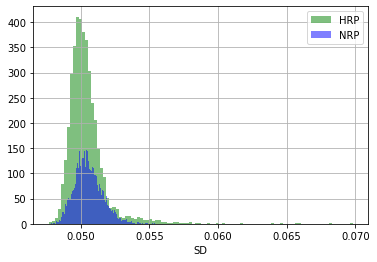

In [9]:
result['performance_hrp.sd_df'].to_pandas()['portfolio'].hist(bins=100, color='g', alpha=.5, label='HRP')
result['performance_nrp.sd_df'].to_pandas()['portfolio'].hist(bins=100, color='b', alpha=.5, label='NRP')
pl.xlabel('SD')
pl.legend()

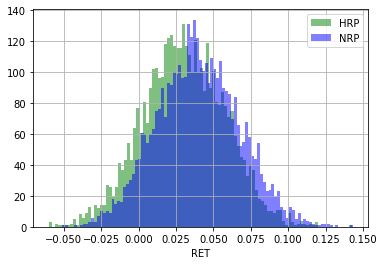

In [10]:
result['performance_hrp.ret_df'].to_pandas()['portfolio'].hist(bins=100, color='g', alpha=.5, label='HRP')
result['performance_nrp.ret_df'].to_pandas()['portfolio'].hist(bins=100, color='b', alpha=.5, label='NRP')
pl.xlabel('RET')
pl.legend()

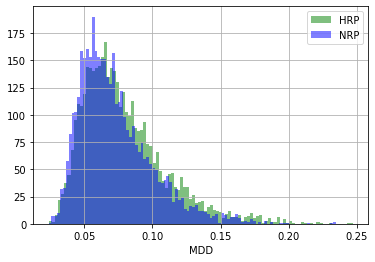

In [11]:
result['performance_hrp.maxdd_df'].to_pandas()['portfolio'].hist(bins=100, color='g', alpha=.5, label='HRP')
result['performance_nrp.maxdd_df'].to_pandas()['portfolio'].hist(bins=100, color='b', alpha=.5, label='NRP')
pl.xlabel('MDD')
pl.legend()

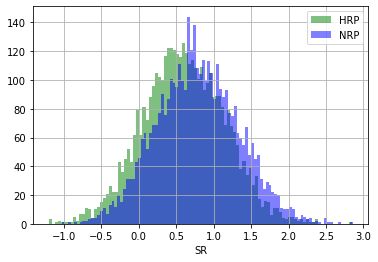

In [12]:
result['performance_hrp.sharpe_df'].to_pandas()['portfolio'].hist(bins=100, color='g', alpha=.5, label='HRP')
result['performance_nrp.sharpe_df'].to_pandas()['portfolio'].hist(bins=100, color='b', alpha=.5, label='NRP')
pl.xlabel('SR')
pl.legend()

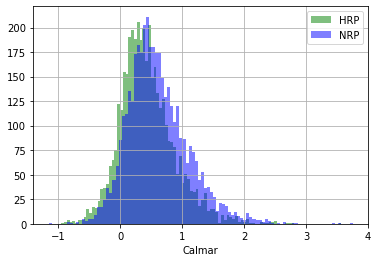

In [13]:
result['performance_hrp.calmar_df'].to_pandas()['portfolio'].hist(bins=100, color='g', alpha=.5, label='HRP')
result['performance_nrp.calmar_df'].to_pandas()['portfolio'].hist(bins=100, color='b', alpha=.5, label='NRP')
pl.xlabel('Calmar')
pl.legend()

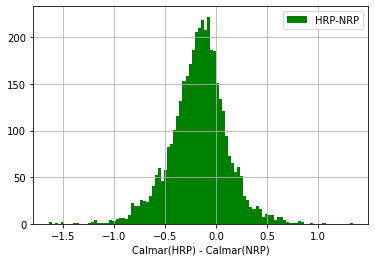

In [14]:
result['hrp_nrp_diff.out'].to_pandas()['portfolio'].hist(bins=100, color='g', label='HRP-NRP')
pl.xlabel('Calmar(HRP) - Calmar(NRP)')
pl.legend()

## Interpretable Machine Learning
In this section, we train a supervised learnin gmodel to fit the spread between the Calmar ratios of HRP and the NRP using statistical features of the bootstrapped
datasets. 

**The features**

To characterize the portfolio universe, we select a set of classical statistical features plus a set of quantities that can indicate properties of the hierarchical structure of the asset universe. This particular set of features is tailored to both strategies, and without the help of ML it would be quite difficult to link them to the performances of the strategies. We also look at some features that encode non-stationarity properties. Whenever the feature name has the suffix `_std`., we measure the standard deviation of the statistical property across time. That helps to identify the heterogeneity of that property across the years. 

In total, we use 30 features associated with the portfolio universe. For example, X_mean_mean identifies the mean across assets of the mean returns across time. In other words, it provides information regarding the overall trend of the returns of the full portfolio. The `X_mean_mean_std` instead represents how the overall trend changes across years and is measured by the standard deviation of the `X_mean_means` measured year by year. Another feature is `X_mean_std` that measures the heterogeneity of the returns across the assets. A high value of this quantity means that the overall trend of the returns is characterized by a very heterogeneous behaviour across assets (in general features that have names ending with `X_std` have been measured with the standard deviation of X across assets).  `corr_mean` is the mean of the entries of the correlation matrix (only the lower diagonal terms) and together with `corr_std` (their standard deviation) they provide information on the independence of the asset from the rest of the universe. For example, a negative value of `corr_mean` suggests that there is a high number of assets that are anti-correlated. A value close to zero can represent either a portfolio with independent assets or one with the same degree of positive and negative correlations. In this case, `corr_std` would discriminate between the two possibilities. 

Following is the workflow to calculate all the features for each bootstrap sample in the GPU

In [15]:

taskGraph=TaskGraph.load_taskgraph('./10assets/feature_computation_workflow.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', 'load_raw_csv'), ('type', 'LoadCsvNode'), ('conf', {'cs…

In [16]:
del result
result = taskGraph.run()
result['merge_features.merged']

,sample_id,max_drawdown_mean_mean,max_drawdown_std_mean,max_raise_mean_mean,max_raise_std_mean,mean_mean_mean,mean_std_mean,std_mean_mean,std_std_mean,corr_mean_mean,...,all_max_drawdown_mean,all_max_drawdown_std,all_max_raise_mean,all_max_raise_std,all_mean_mean,all_mean_std,all_std_mean,all_std_std,all_corr_mean,all_corr_std
0,22,0.176416,0.095631,0.192303,0.146995,0.000203,0.000974,0.012915,0.009130,-1.055735,...,0.349777,0.136918,0.367973,0.243854,0.000148,0.000414,0.013716,0.010887,-1.034114,0.278906
1,1249,0.181873,0.156775,0.226293,0.164977,0.000269,0.001311,0.014357,0.013818,-1.018066,...,0.360368,0.262738,0.469101,0.273491,0.000166,0.000404,0.014589,0.013851,-1.004115,0.227904
2,3568,0.176569,0.128164,0.215762,0.140299,0.000231,0.000885,0.013211,0.011684,-0.992657,...,0.314663,0.206896,0.421162,0.215571,0.000152,0.000383,0.013982,0.013007,-0.995195,0.219224
3,2598,0.166143,0.121703,0.238475,0.170449,0.000517,0.000993,0.013401,0.010718,-1.024536,...,0.318151,0.211908,0.507258,0.251878,0.000362,0.000286,0.014349,0.012514,-1.014872,0.221090
4,1930,0.206856,0.165912,0.193074,0.142022,-0.000125,0.000986,0.013689,0.011481,-1.017073,...,0.403788,0.280982,0.377307,0.253049,-0.000086,0.000341,0.014013,0.012013,-1.006200,0.216680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,3302,0.190948,0.148667,0.209096,0.125466,0.000105,0.000902,0.013007,0.009427,-1.006735,...,0.336825,0.267728,0.468350,0.236357,0.000158,0.000491,0.013552,0.010356,-1.007045,0.207703
4092,3410,0.184899,0.147866,0.205385,0.125274,0.000110,0.000824,0.014812,0.014564,-0.989385,...,0.322167,0.217932,0.410073,0.190860,0.000188,0.000574,0.015308,0.015071,-0.981466,0.182483
4093,3199,0.159363,0.107570,0.211365,0.165283,0.000420,0.001046,0.012902,0.010509,-0.979472,...,0.309529,0.143644,0.440456,0.297073,0.000396,0.000562,0.013331,0.010546,-0.977893,0.225161
4094,2934,0.157729,0.120455,0.214026,0.129746,0.000365,0.000820,0.012403,0.009693,-1.007913,...,0.287158,0.180682,0.504911,0.215656,0.000454,0.000394,0.012883,0.010030,-0.997404,0.211986


The taskgrpah is a bit complicated, we can use `CompositeNode` to group the sub-graph into a single node. Here is a simplified version of it:

In [17]:
taskGraph=TaskGraph.load_taskgraph('./10assets/all_feature_simplified.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', ''), ('type', 'Output_Collector'), ('conf', {}), ('inpu…

In [18]:
del result
result = taskGraph.run()
result['merge_features.merged']

,sample_id,max_drawdown_mean_mean,max_drawdown_std_mean,max_raise_mean_mean,max_raise_std_mean,mean_mean_mean,mean_std_mean,std_mean_mean,std_std_mean,corr_mean_mean,...,all_max_drawdown_mean,all_max_drawdown_std,all_max_raise_mean,all_max_raise_std,all_mean_mean,all_mean_std,all_std_mean,all_std_std,all_corr_mean,all_corr_std
0,22,0.173659,0.135088,0.226749,0.157039,0.000398,0.001084,0.013783,0.011794,-1.024777,...,0.297211,0.207056,0.500612,0.254519,0.000440,0.000328,0.013745,0.011373,-1.013396,0.248013
1,1249,0.188303,0.124149,0.194538,0.133568,0.000065,0.000785,0.013674,0.010545,-1.018417,...,0.342482,0.185580,0.354623,0.206725,0.000118,0.000449,0.013837,0.010782,-1.020288,0.279852
2,3568,0.176261,0.155812,0.220231,0.151087,0.000256,0.001033,0.014769,0.015037,-1.008509,...,0.308801,0.245480,0.482616,0.213013,0.000237,0.000305,0.014966,0.014873,-1.013802,0.252676
3,2598,0.170760,0.167172,0.227641,0.146236,0.000270,0.001381,0.014309,0.014515,-1.021870,...,0.290197,0.257702,0.510380,0.226090,0.000244,0.000787,0.014527,0.014333,-1.006859,0.213735
4,1930,0.170653,0.100185,0.211752,0.141862,0.000315,0.000734,0.013081,0.009109,-1.008503,...,0.315233,0.201236,0.426444,0.212346,0.000200,0.000216,0.014163,0.011642,-0.992289,0.196866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,3258,0.164313,0.103732,0.228614,0.146641,0.000478,0.000957,0.012860,0.009242,-1.008706,...,0.308961,0.178351,0.485884,0.216145,0.000439,0.000544,0.013735,0.010652,-1.006229,0.220487
4092,3728,0.152966,0.112628,0.236712,0.160161,0.000565,0.000951,0.013274,0.011257,-1.013875,...,0.285682,0.182101,0.506137,0.280975,0.000448,0.000449,0.013813,0.012394,-1.001975,0.220471
4093,3205,0.164776,0.120788,0.219466,0.153699,0.000432,0.000980,0.013480,0.010878,-1.024082,...,0.301578,0.196289,0.460841,0.234073,0.000359,0.000683,0.013445,0.010651,-1.001315,0.237917
4094,160,0.191815,0.139479,0.204406,0.129679,0.000103,0.000825,0.013187,0.010509,-0.994630,...,0.338309,0.205523,0.393980,0.205176,0.000142,0.000105,0.014205,0.012114,-0.983178,0.192838


## The ML learning model

For the supervised learning algorithm, we selected XGBoost (Chen and Guestrin (2016)) , a gradient tree boosting library that is fast and accurate as described in the paper. This algorithm can construct non-linear relations among the features. Moreover, for large datasets, it can scale across GPUs to speed-up the learning process. Another benefit of using XGBoost is that it produces fast explanations.

To assess the stability of the explanations, the set of bootstrapped datasets, each across 17 multi-asset futures, is split into 90% training and 10% test set. We trained the model as a regression, to learn the difference between the Calmar ratio obtained with HRP minus the Calmar ratio obtained by HRP. 

In [19]:
taskGraph=TaskGraph.load_taskgraph('./10assets/xgboost_performance.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', ''), ('type', 'Output_Collector'), ('conf', {}), ('inpu…

Run and collect the results:

In [20]:
del result
result = taskGraph.run()

Let's check the R-squared score for both Train dataset and Test dataset

In [21]:
print('Train R-Squared:', result['train_rsquared.out'], 'Test R-Squared:', result['test_rsquared.out'])

Train R-Squared: 0.9996299925728722 Test R-Squared: 0.1754622554831603


Text(0.5, 1.0, 'Test')

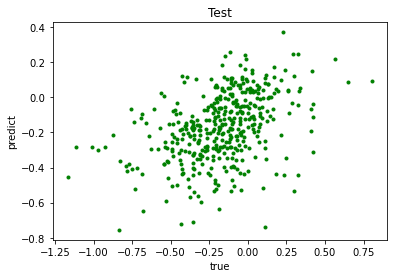

In [22]:
pl.plot(result['test_infer.out'].portfolio.values.get(), result['test_infer.out'].predict.values.get(), 'g.')
pl.xlabel('true')
pl.ylabel('predict')
pl.title('Test')

Text(0.5, 1.0, 'Train')

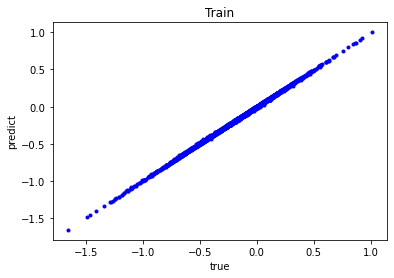

In [23]:
pl.plot(result['train_infer.out'].portfolio.values.get(), result['train_infer.out'].predict.values.get(), 'b.')
pl.xlabel('true')
pl.ylabel('predict')
pl.title('Train')

Clearly the XGBoost model is over-fitted as we only use 4096 data points. We will use more data points later

## The explanation method

We will use Shapley values of feature contribution to explain the ML result. In simple words, what Shapley values tell us is how much each feature (the statistical properties of the asset universe described above) has contributed to a specific outcome of the ML model. Because of the complexity (non-linearity) of the model, this is a non-trivial task. The Shapley value is a quantity introduced in co-operative game theory to provide the fair payout to a player (the features) with respect to its contribution to the common goal (ML prediction). The SHAP framework (Lundberg and Lee (2017)) provides a tool to evaluate this quantity even in a model agnostic way. It allows comparing these quantitative explanations among different models.

Shapley values can be computed from the XGboost inference node. Following is the workflow to visualize the feature contributions. 

In [24]:
taskGraph=TaskGraph.load_taskgraph('./10assets/xgboost_shap.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', ''), ('type', 'Output_Collector'), ('conf', {}), ('inpu…

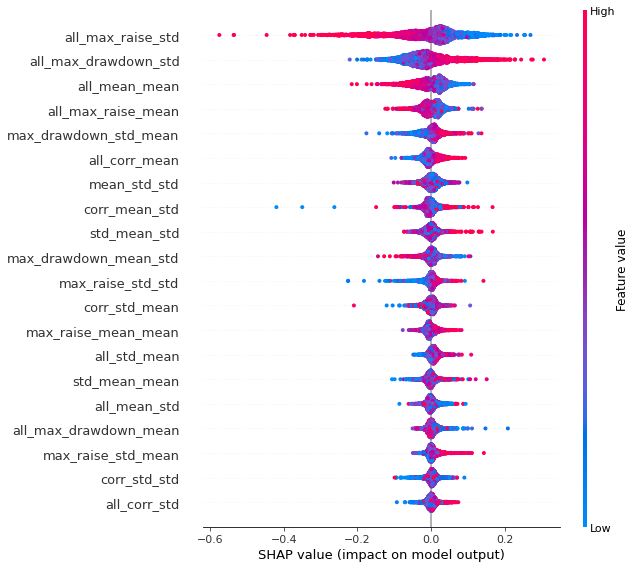

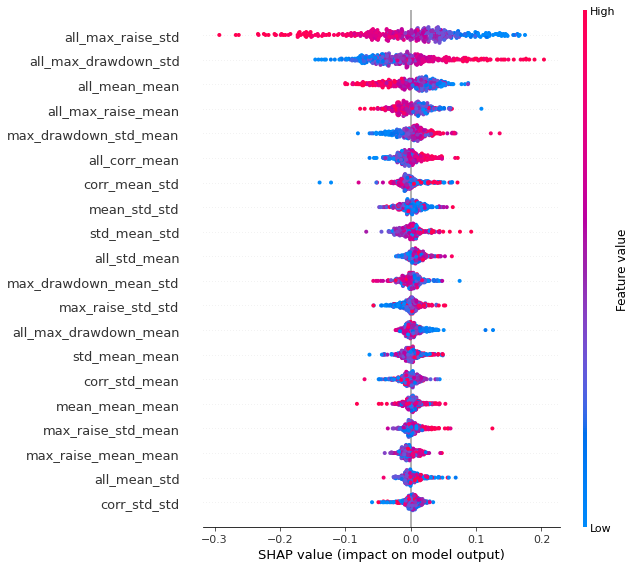

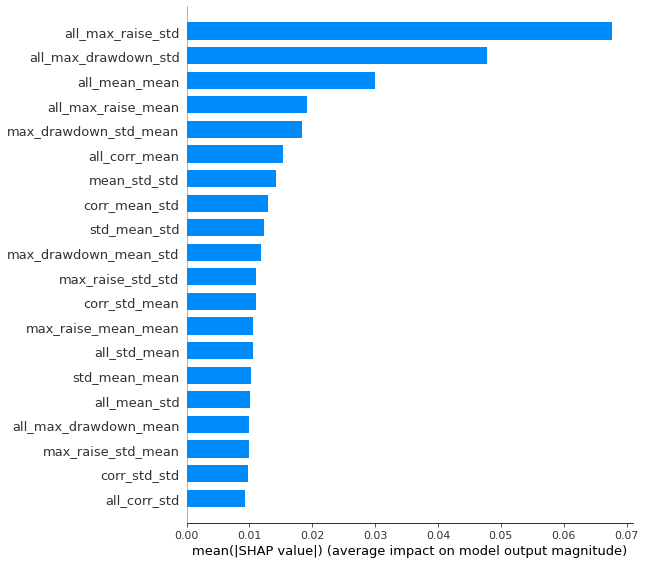

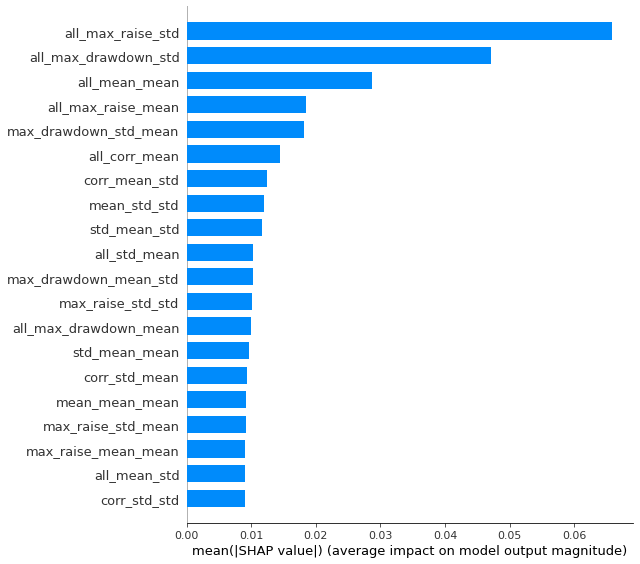

In [25]:
del result
result = taskGraph.run()

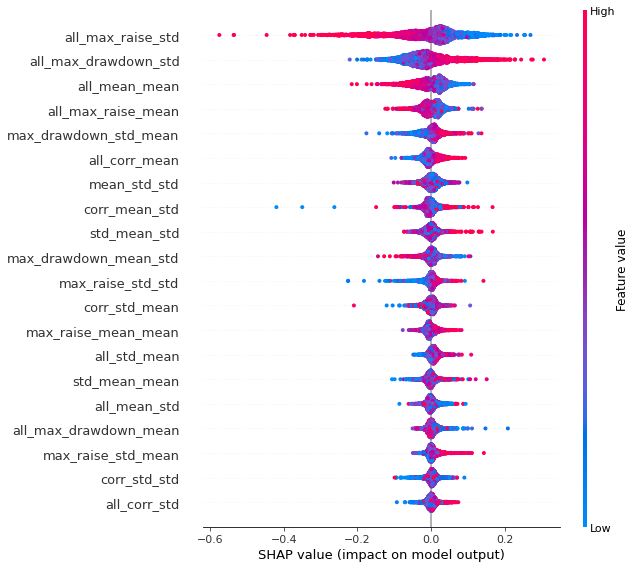

In [26]:
display(HTML('<h1>Shap Summary, Train</h1>'))
result['train_shap_dot.summary_plot']

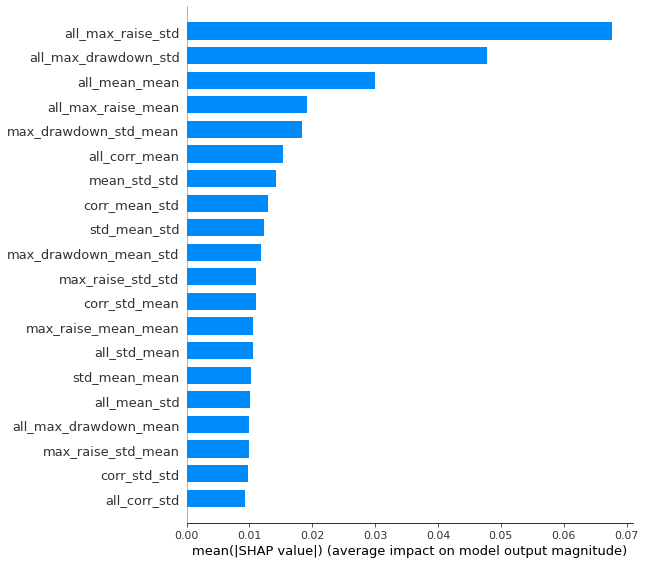

In [27]:
display(HTML('<h1>Shap Summary, Train</h1>'))
result['train_shap_bar.summary_plot']

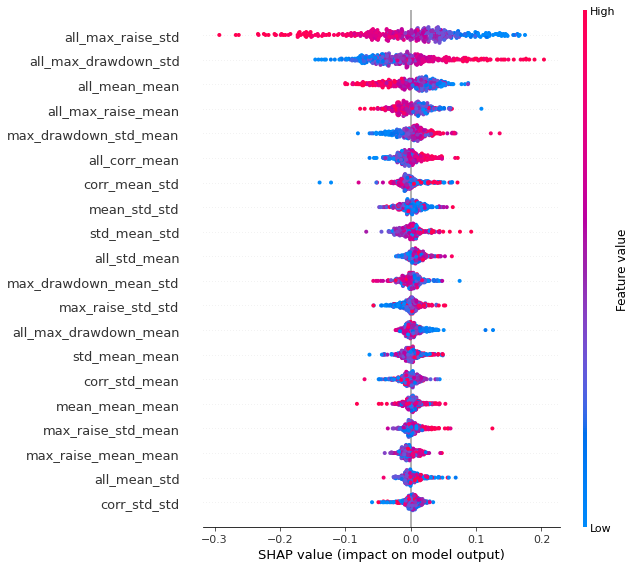

In [28]:
display(HTML('<h1>Shap Summary, Test</h1>'))
result['test_shap_dot.summary_plot']

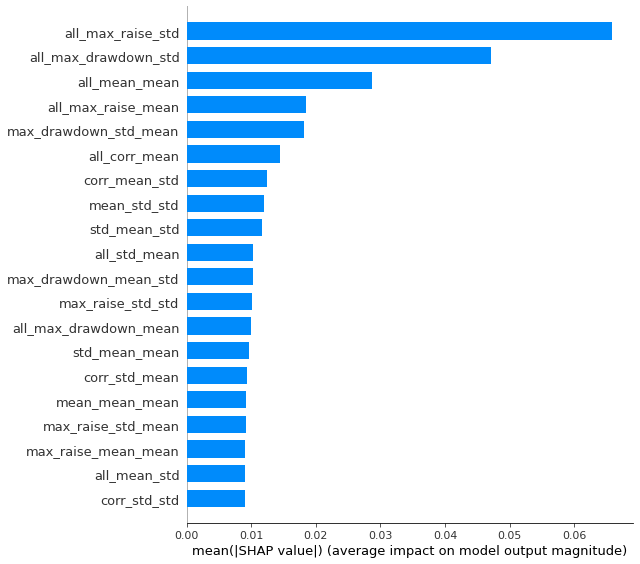

In [29]:
display(HTML('<h1>Shap Summary, Test</h1>'))
result['test_shap_bar.summary_plot']

## Scale to 100K Samples

The maximum number of samples that can be computed in a single 32G V100 GPU is 4096. To compute 100K samples, we use Dask to distribute the workloads in multiple GPUs.


In [30]:
taskGraph=TaskGraph.load_taskgraph('./10assets/parallel_xgboost_shap.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', ''), ('type', 'Output_Collector'), ('conf', {}), ('inpu…

[07:29:48] task [xgboost.dask]:tcp://127.0.0.1:41265 got new rank 0
[07:29:48] task [xgboost.dask]:tcp://127.0.0.1:37729 got new rank 1
[07:29:48] task [xgboost.dask]:tcp://127.0.0.1:38753 got new rank 2
[07:29:49] task [xgboost.dask]:tcp://127.0.0.1:38983 got new rank 3


CPU times: user 10.6 s, sys: 967 ms, total: 11.6 s
Wall time: 1min 8s


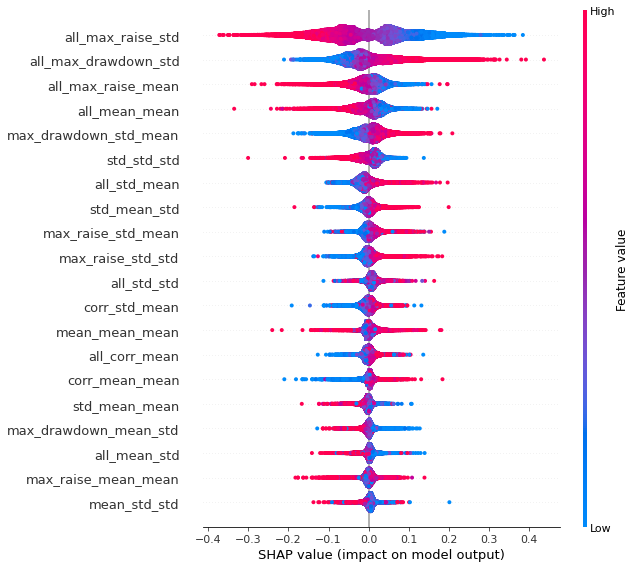

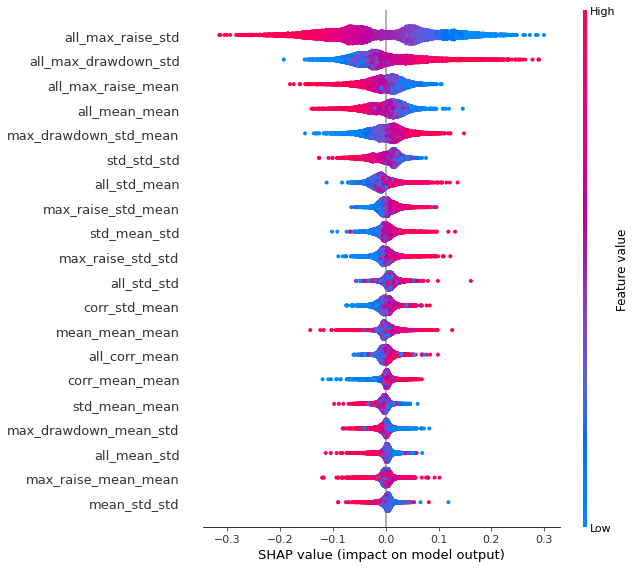

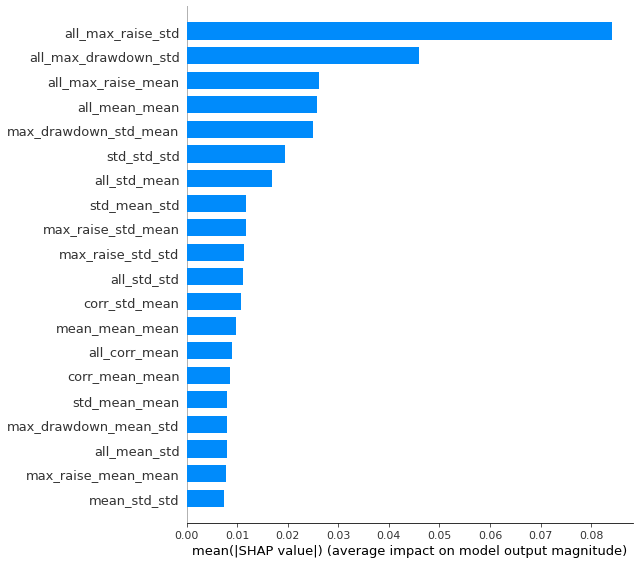

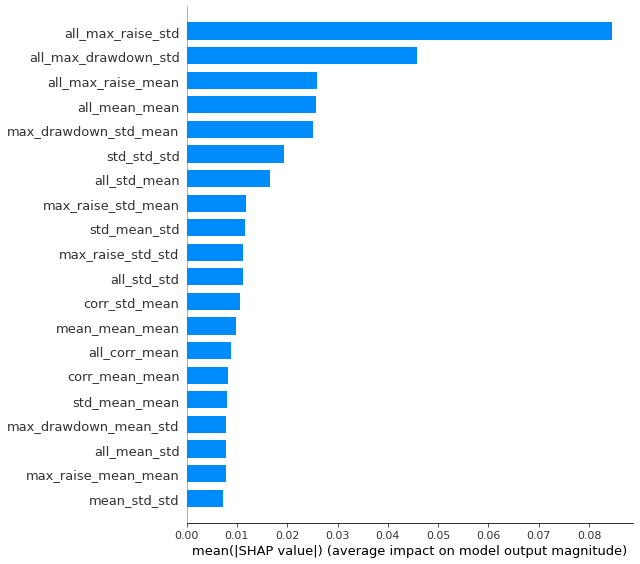

In [31]:
del result
%time result = taskGraph.run()

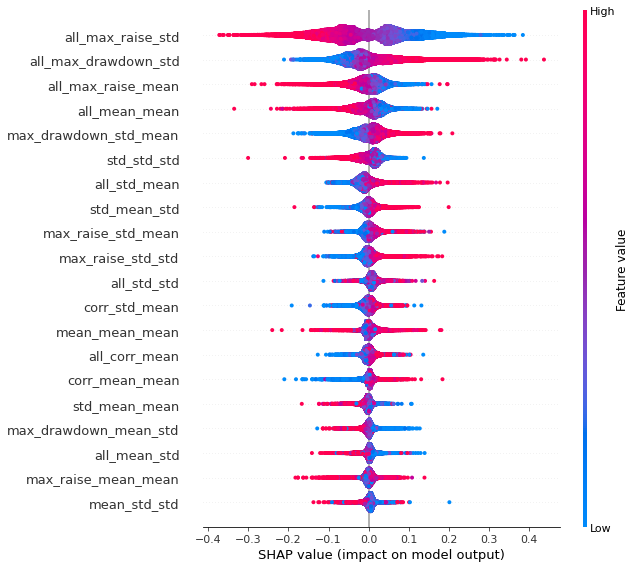

In [32]:
display(HTML('<h1>Shap Summary, Train</h1>'))
result['train_shap_dot.summary_plot']

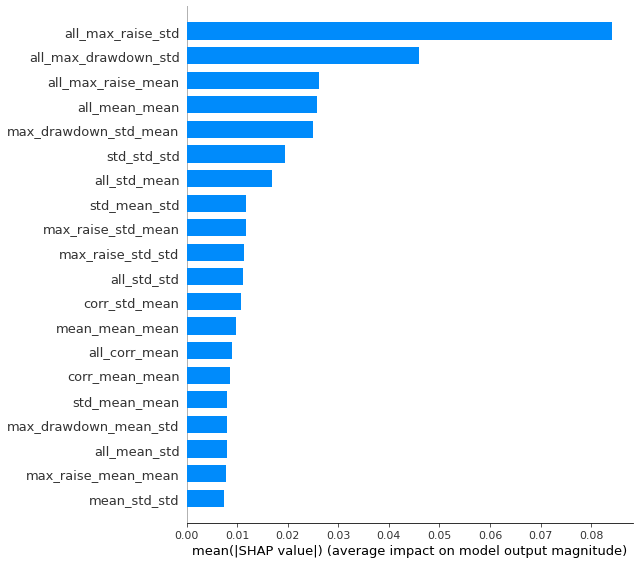

In [33]:
display(HTML('<h1>Shap Summary, Train</h1>'))
result['train_shap_bar.summary_plot']

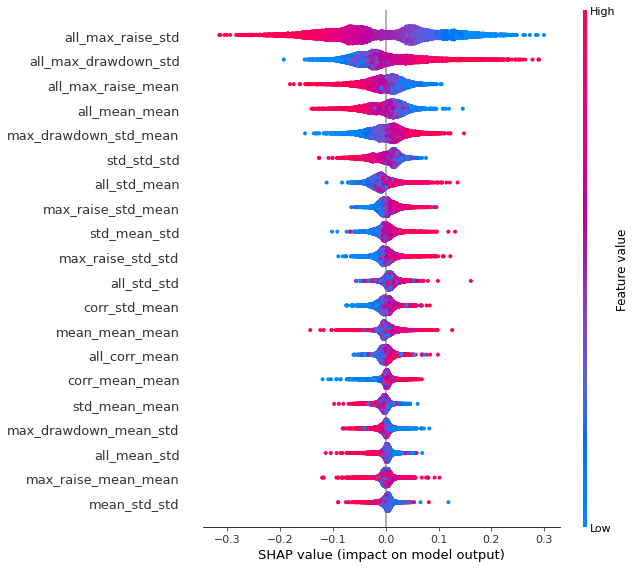

In [34]:
display(HTML('<h1>Shap Summary, Test</h1>'))
result['test_shap_dot.summary_plot']

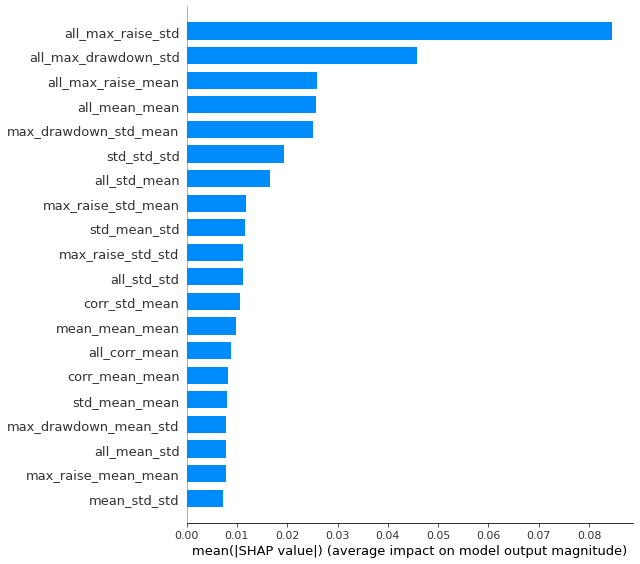

In [35]:
display(HTML('<h1>Shap Summary, Test</h1>'))
result['test_shap_bar.summary_plot']

We run the XGboost performance metrics again for 100K samples:

In [36]:
taskGraph=TaskGraph.load_taskgraph('./10assets/parallel_xgboost_performance.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', ''), ('type', 'Output_Collector'), ('conf', {}), ('inpu…

In [37]:
%time result = taskGraph.run()

[07:31:25] task [xgboost.dask]:tcp://127.0.0.1:38753 got new rank 0
[07:31:25] task [xgboost.dask]:tcp://127.0.0.1:37729 got new rank 1
[07:31:25] task [xgboost.dask]:tcp://127.0.0.1:38983 got new rank 2
[07:31:25] task [xgboost.dask]:tcp://127.0.0.1:41265 got new rank 3


CPU times: user 5.7 s, sys: 801 ms, total: 6.51 s
Wall time: 1min 3s


In [38]:
print('Train R-Squared:', result['train_rsquared.out'], 'Test R-Squared:', result['test_rsquared.out'])

Train R-Squared: 0.6702959795607364 Test R-Squared: 0.2611768812882351


In [39]:
train_infer_df = result['train_infer.out'].compute()
test_infer_df = result['test_infer.out'].compute()

Text(0.5, 1.0, 'Train')

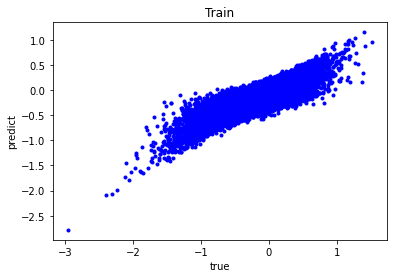

In [40]:
pl.plot(train_infer_df.portfolio.values.get(), train_infer_df.predict.values.get(), 'b.')
pl.xlabel('true')
pl.ylabel('predict')
pl.title('Train')

Text(0.5, 1.0, 'Test')

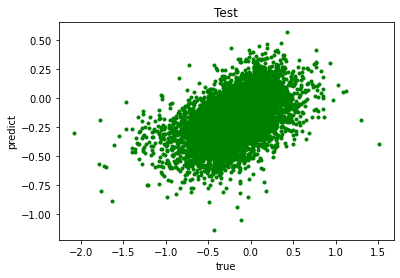

In [41]:
pl.plot(test_infer_df.portfolio.values.get(), test_infer_df.predict.values.get(), 'g.')
pl.xlabel('true')
pl.ylabel('predict')
pl.title('Test')

## Hyperparameter Optimization

When data scientists are building machine learning models, there are a few magic numbers that are included in the model. The example numbers are depths in the tree, the learning rate, etc. The parameters that define the model architecture or training process are usually referred to as hyperparameters. They are magical because there is no good theory about what number to choose. Commonly, the hyperparameters can be searched to find a good set of them that results in the best model performance. The process of searching is referred to as hyperparameter tuning.

There are a few popular Python-based hyperparameter tuning libraries existing: Ray Tune, Optuna, HyperOpt. Each library provides a set of search algorithms and schedule algorithms that is easy to use.

Inside the `greenflow` project, we implemented a Context Composite Node that can flexibly expose the hyperparameters that are interesting for tuning. The Context Composite Node makes hyperparameter tuning easy to do by leveraging the hyperparameter tuning libraries. Inside `greenflow_gquant_plugin` project, there is a `GridRandomSearchNode` that can do random and grid search with Ray Tune library for the hyperparameters. First, we need to initialize the ray tune environment.

In [42]:
import ray
ray.init()

2021-09-11 07:33:34,734	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '10.110.106.133',
 'raylet_ip_address': '10.110.106.133',
 'redis_address': '10.110.106.133:6379',
 'object_store_address': '/tmp/ray/session_2021-09-11_07-33-33_007746_8117/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-09-11_07-33-33_007746_8117/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-09-11_07-33-33_007746_8117',
 'metrics_export_port': 42876,
 'node_id': '957622d9af34e4b71ba298336c2ef21a93fdd161aca955b2ac3df17b'}

Following is the workflow to run HPO. As a simple example, we will search the `num_rounds` and `eta` parameters in the XGBoost model. We use grid search for `num_rounds` and random search for `eta`. Click on the `GridRandomSearchNode`, you can see how we configure the search space.

In [43]:
taskGraph=TaskGraph.load_taskgraph('./10assets/hpo.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', 'xgboost_train'), ('type', 'ContextCompositeNode'), ('c…

In [44]:
taskGraph.run()

Trial name,status,loc,eta,num_rounds
search_fun_41421_00000,PENDING,,0.429192,100
search_fun_41421_00001,PENDING,,0.112773,110
search_fun_41421_00002,PENDING,,0.175494,120


(pid=8430) Port 8787 is already in use.
(pid=8430) Perhaps you already have a cluster running?
(pid=8430) Hosting the HTTP server on port 33341 instead


Trial name,status,loc,eta,num_rounds
search_fun_41421_00000,RUNNING,,0.429192,100
search_fun_41421_00001,PENDING,,0.112773,110
search_fun_41421_00002,PENDING,,0.175494,120


(pid=8430) start new Cluster


Trial name,status,loc,eta,num_rounds
search_fun_41421_00000,RUNNING,,0.429192,100
search_fun_41421_00001,PENDING,,0.112773,110
search_fun_41421_00002,PENDING,,0.175494,120


(pid=8430) [07:34:42] task [xgboost.dask]:tcp://127.0.0.1:42805 got new rank 0
(pid=8430) [07:34:42] task [xgboost.dask]:tcp://127.0.0.1:36479 got new rank 1
(pid=8430) [07:34:42] task [xgboost.dask]:tcp://127.0.0.1:37399 got new rank 2
(pid=8430) [07:34:42] task [xgboost.dask]:tcp://127.0.0.1:40657 got new rank 3


Result for search_fun_41421_00000:
  date: 2021-09-11_07-34-48
  done: false
  experiment_id: 66602f73733f4e3eb5a28ad019609fc8
  hostname: dgx-rpd-05
  iterations_since_restore: 1
  node_ip: 10.110.106.133
  pid: 8430
  test_rsquared.out: 0.23059997032051788
  time_since_restore: 66.5236747264862
  time_this_iter_s: 66.5236747264862
  time_total_s: 66.5236747264862
  timestamp: 1631370888
  timesteps_since_restore: 0
  train_rsquared.out: 0.727480413972756
  training_iteration: 1
  trial_id: '41421_00000'
  


Trial name,status,loc,eta,num_rounds,iter,total time (s),train_rsquared.out,test_rsquared.out
search_fun_41421_00000,RUNNING,10.110.106.133:8430,0.429192,100,1,66.5237,0.72748,0.2306
search_fun_41421_00001,PENDING,,0.112773,110,,,,
search_fun_41421_00002,PENDING,,0.175494,120,,,,


Result for search_fun_41421_00000:
  date: 2021-09-11_07-34-48
  done: true
  experiment_id: 66602f73733f4e3eb5a28ad019609fc8
  experiment_tag: 0_eta=0.42919,num_rounds=100
  hostname: dgx-rpd-05
  iterations_since_restore: 1
  node_ip: 10.110.106.133
  pid: 8430
  test_rsquared.out: 0.23059997032051788
  time_since_restore: 66.5236747264862
  time_this_iter_s: 66.5236747264862
  time_total_s: 66.5236747264862
  timestamp: 1631370888
  timesteps_since_restore: 0
  train_rsquared.out: 0.727480413972756
  training_iteration: 1
  trial_id: '41421_00000'
  


(pid=8430) /raid/yi/conda/miniconda3/envs/rapids-21.08/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 24 leaked semaphore objects to clean up at shutdown
(pid=8430)   warnings.warn('resource_tracker: There appear to be %d '
(pid=8435) Port 8787 is already in use.
(pid=8435) Perhaps you already have a cluster running?
(pid=8435) Hosting the HTTP server on port 33703 instead


(pid=8435) start new Cluster


(pid=8435) [07:35:50] task [xgboost.dask]:tcp://127.0.0.1:36713 got new rank 0
(pid=8435) [07:35:51] task [xgboost.dask]:tcp://127.0.0.1:39959 got new rank 1
(pid=8435) [07:35:51] task [xgboost.dask]:tcp://127.0.0.1:37229 got new rank 2
(pid=8435) [07:35:51] task [xgboost.dask]:tcp://127.0.0.1:43649 got new rank 3


Result for search_fun_41421_00001:
  date: 2021-09-11_07-35-56
  done: false
  experiment_id: b6d145e8222b4cad986d783f204ec387
  hostname: dgx-rpd-05
  iterations_since_restore: 1
  node_ip: 10.110.106.133
  pid: 8435
  test_rsquared.out: 0.27798860731228553
  time_since_restore: 66.65757536888123
  time_this_iter_s: 66.65757536888123
  time_total_s: 66.65757536888123
  timestamp: 1631370956
  timesteps_since_restore: 0
  train_rsquared.out: 0.5292758936614704
  training_iteration: 1
  trial_id: '41421_00001'
  


Trial name,status,loc,eta,num_rounds,iter,total time (s),train_rsquared.out,test_rsquared.out
search_fun_41421_00001,RUNNING,10.110.106.133:8435,0.112773,110,1,66.6576,0.529276,0.277989
search_fun_41421_00002,PENDING,,0.175494,120,,,,
search_fun_41421_00000,TERMINATED,,0.429192,100,1,66.5237,0.72748,0.2306


Result for search_fun_41421_00001:
  date: 2021-09-11_07-35-56
  done: true
  experiment_id: b6d145e8222b4cad986d783f204ec387
  experiment_tag: 1_eta=0.11277,num_rounds=110
  hostname: dgx-rpd-05
  iterations_since_restore: 1
  node_ip: 10.110.106.133
  pid: 8435
  test_rsquared.out: 0.27798860731228553
  time_since_restore: 66.65757536888123
  time_this_iter_s: 66.65757536888123
  time_total_s: 66.65757536888123
  timestamp: 1631370956
  timesteps_since_restore: 0
  train_rsquared.out: 0.5292758936614704
  training_iteration: 1
  trial_id: '41421_00001'
  


(pid=8435) /raid/yi/conda/miniconda3/envs/rapids-21.08/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 24 leaked semaphore objects to clean up at shutdown
(pid=8435)   warnings.warn('resource_tracker: There appear to be %d '
(pid=8431) Port 8787 is already in use.
(pid=8431) Perhaps you already have a cluster running?
(pid=8431) Hosting the HTTP server on port 35363 instead


(pid=8431) start new Cluster


(pid=8431) [07:37:00] task [xgboost.dask]:tcp://127.0.0.1:40215 got new rank 0
(pid=8431) [07:37:00] task [xgboost.dask]:tcp://127.0.0.1:37699 got new rank 1
(pid=8431) [07:37:01] task [xgboost.dask]:tcp://127.0.0.1:39005 got new rank 2
(pid=8431) [07:37:01] task [xgboost.dask]:tcp://127.0.0.1:39459 got new rank 3


Result for search_fun_41421_00002:
  date: 2021-09-11_07-37-06
  done: false
  experiment_id: 3b977bcab05a490dad85778cd40775db
  hostname: dgx-rpd-05
  iterations_since_restore: 1
  node_ip: 10.110.106.133
  pid: 8431
  test_rsquared.out: 0.26896401233828526
  time_since_restore: 67.81491684913635
  time_this_iter_s: 67.81491684913635
  time_total_s: 67.81491684913635
  timestamp: 1631371026
  timesteps_since_restore: 0
  train_rsquared.out: 0.6088050961934768
  training_iteration: 1
  trial_id: '41421_00002'
  


Trial name,status,loc,eta,num_rounds,iter,total time (s),train_rsquared.out,test_rsquared.out
search_fun_41421_00002,RUNNING,10.110.106.133:8431,0.175494,120,1,67.8149,0.608805,0.268964
search_fun_41421_00000,TERMINATED,,0.429192,100,1,66.5237,0.72748,0.2306
search_fun_41421_00001,TERMINATED,,0.112773,110,1,66.6576,0.529276,0.277989


Result for search_fun_41421_00002:
  date: 2021-09-11_07-37-06
  done: true
  experiment_id: 3b977bcab05a490dad85778cd40775db
  experiment_tag: 2_eta=0.17549,num_rounds=120
  hostname: dgx-rpd-05
  iterations_since_restore: 1
  node_ip: 10.110.106.133
  pid: 8431
  test_rsquared.out: 0.26896401233828526
  time_since_restore: 67.81491684913635
  time_this_iter_s: 67.81491684913635
  time_total_s: 67.81491684913635
  timestamp: 1631371026
  timesteps_since_restore: 0
  train_rsquared.out: 0.6088050961934768
  training_iteration: 1
  trial_id: '41421_00002'
  


Trial name,status,loc,eta,num_rounds,iter,total time (s),train_rsquared.out,test_rsquared.out
search_fun_41421_00000,TERMINATED,,0.429192,100,1,66.5237,0.72748,0.2306
search_fun_41421_00001,TERMINATED,,0.112773,110,1,66.6576,0.529276,0.277989
search_fun_41421_00002,TERMINATED,,0.175494,120,1,67.8149,0.608805,0.268964


2021-09-11 07:37:07,095	INFO tune.py:561 -- Total run time: 207.90 seconds (207.76 seconds for the tuning loop).
(pid=8431) /raid/yi/conda/miniconda3/envs/rapids-21.08/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 24 leaked semaphore objects to clean up at shutdown
(pid=8431)   warnings.warn('resource_tracker: There appear to be %d '
[07:37:58] task [xgboost.dask]:tcp://127.0.0.1:37729 got new rank 0
[07:37:58] task [xgboost.dask]:tcp://127.0.0.1:38753 got new rank 1
[07:37:58] task [xgboost.dask]:tcp://127.0.0.1:41265 got new rank 2
[07:37:58] task [xgboost.dask]:tcp://127.0.0.1:38983 got new rank 3


Results([('grid_search.conf_out', <greenflow.plugin_nodes.util.data_obj.ConfData object at 0x7f879229b970>), ('grid_search.test_rsquared@out', 0.28047657615542004)])

In above simple HPO run, we see more rounds in the XGBoost training help to increase the test R-squared score. HPO is a time consuming process, GPU make it possible as we reduce the time to run 100K bootstrap samples from days in CPU cluster to 4 mins in DGX station. Feel free to add more hyperparamerters and increase the number of trails in above workflow.